In [99]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import math
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from importlib import reload
import itertools
import warnings
warnings.filterwarnings('ignore')

## Preprocess data

In [37]:
PATH = 'rainfall_data_1901_to_2002.xlsx'

In [38]:
data = pd.read_excel(PATH)

In [39]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))
data.head()

,State,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Andhra Pradesh,Adilabad,1901,6.725,10.488,23.288,35.560,23.119,115.546,294.119,276.865,181.615,47.310,1.339,0.000
1,Andhra Pradesh,Adilabad,1902,0.420,0.000,0.388,6.070,3.331,45.960,233.973,167.971,198.177,26.447,35.083,11.222
2,Andhra Pradesh,Adilabad,1903,6.643,1.956,0.173,4.551,33.348,132.078,436.611,334.544,226.037,138.818,14.095,8.823
3,Andhra Pradesh,Adilabad,1904,0.054,0.121,11.446,0.017,16.900,131.048,160.694,81.865,251.577,110.391,0.146,0.130
4,Andhra Pradesh,Adilabad,1905,0.589,2.293,8.252,35.020,17.569,79.937,96.331,313.522,361.697,4.950,0.146,0.000


In [40]:
m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')
m_data.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000


In [41]:
districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

In [42]:
maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.as_matrix().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

maharashtra_data = maharashtra_data.rename(columns={'Gadchiroli': 'Garhchiroli'})
maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


## Correlation matrix - Districts

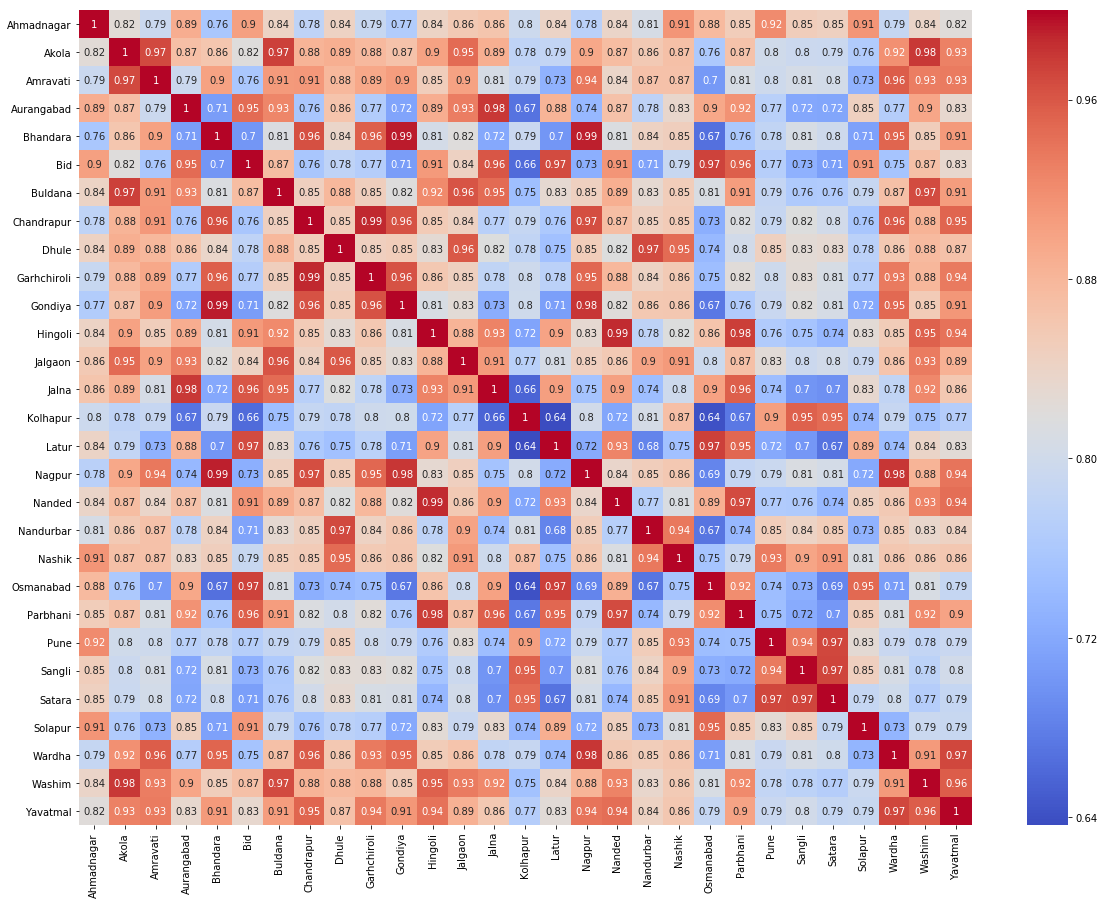

In [43]:
corr_matrix = maharashtra_data.drop(columns=['Year', 'Month']).corr().abs()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Highly correlated districts

In [44]:
def return_highly_correlated(corr_matrix, corr_coef):
    district_corr = corr_matrix.abs().unstack().sort_values().drop_duplicates()
    tuples = district_corr[(district_corr > corr_coef) & (district_corr != 1.0)]
    levels = tuples.index.levels[0]
    labels = tuples.index.labels

    high_corr_districts = []
    for i in range(len(labels[0])):
        high_corr_districts.append([levels[labels[0][i]], levels[labels[1][i]], tuples[i]])
    high_corr_districts = np.array(high_corr_districts)
    df = pd.DataFrame({'District1': high_corr_districts[:, 0], 
                      'District2': high_corr_districts[:, 1],
                      'Correlation_coefficient': high_corr_districts[:, 2]},
                     columns = ['District1', 'District2', 'Correlation_coefficient'])
    return df

In [45]:
high_corr_districts = return_highly_correlated(corr_matrix, 0.98)
high_corr_districts

,District1,District2,Correlation_coefficient
0,Nagpur,Gondiya,0.9805330709528167
1,Nagpur,Wardha,0.9811563634226902
2,Nanded,Hingoli,0.9858166679818119
3,Chandrapur,Garhchiroli,0.9885737788804028
4,Nagpur,Bhandara,0.9907760645844106
5,Bhandara,Gondiya,0.9922307205938624


## Precipitation data of the district "Pune"

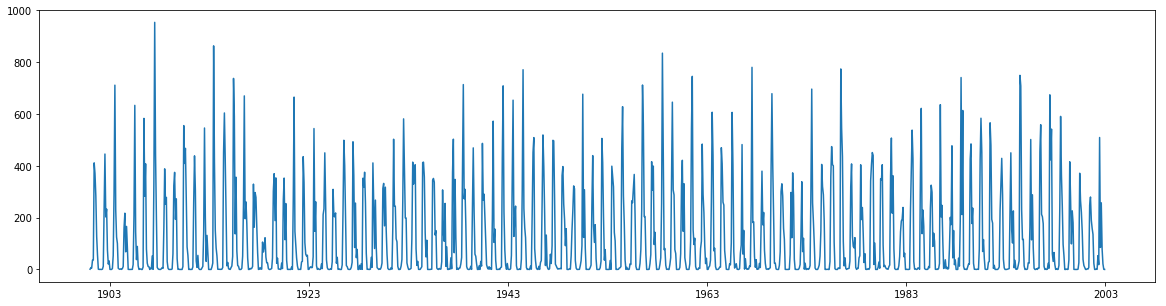

In [46]:
plt.figure(figsize=(20,5))
plt.plot(maharashtra_data.Date, maharashtra_data.Pune)

## Plot the districts with heavy rainfall over all years(>700|800mm)

In [54]:
high_rainfall = {}
districts = maharashtra_data.columns[3:]
for district in districts:
    count = len(maharashtra_data[maharashtra_data[district]>=800])
    if count != 0:
        high_rainfall[district] = count
high_rainfall

{'Kolhapur': 49,
 'Nandurbar': 10,
 'Nashik': 1,
 'Pune': 3,
 'Sangli': 1,
 'Satara': 25}

## Boxplot - District wise precipitation across all years

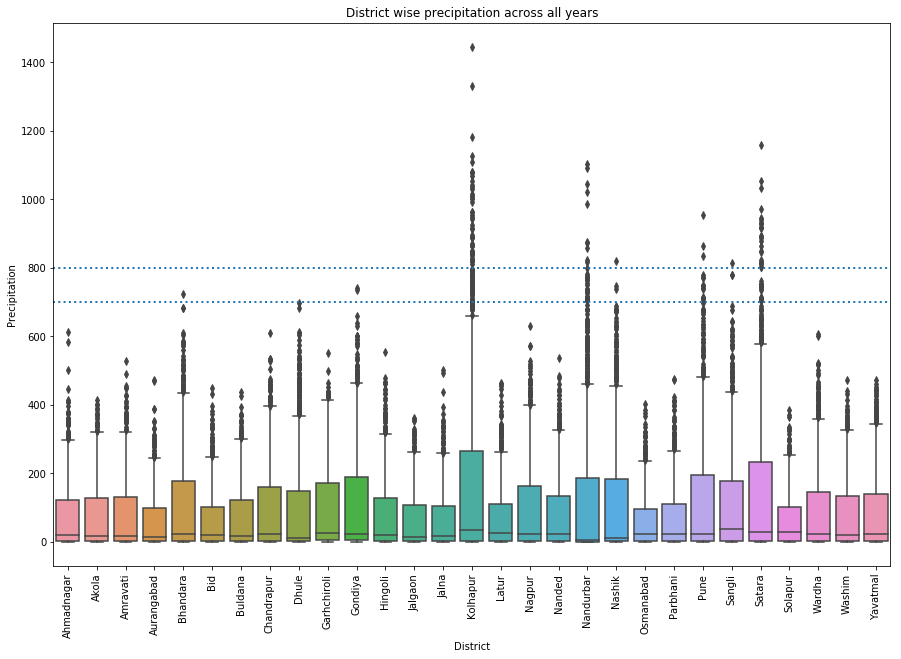

In [55]:
matrix = maharashtra_data.drop(columns=['Date', 'Year', 'Month'])

plt.figure(figsize=(15,10))
g = sns.boxplot(x="variable", y="value", data=pd.melt(matrix))
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation=90)
g.set_xlabel('District')
g.set_ylabel('Precipitation')
g.set_title('District wise precipitation across all years')
plt.axhline(y=700, linewidth=2, linestyle='dotted')
plt.axhline(y=800, linewidth=2, linestyle='dotted')

- In district 'Kolhapur', the precipitation is above 800mm for many times. It says that the rainfall was heavy in Kolhapur district.

## Yearly average precipitation data across all districts in Maharashtra

In [56]:
m_data_copy = maharashtra_data.copy()
m_data_copy = m_data_copy.drop(columns=['Date', 'Year', 'Month'])
m_data_copy = m_data_copy.groupby(np.arange(len(df))//12).mean()
columns = m_data_copy.columns
columns = columns.insert(0, 'Year')
m_data_copy['Year'] = maharashtra_data.Year.unique()
m_data_copy = m_data_copy.reindex(columns=columns)
m_data_copy.set_index('Year', inplace=True)

In [57]:
m_data_copy.head()

,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,Chandrapur,Dhule,Garhchiroli,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
Year,,,,,,,,,,,,,,,,,,,,,
1901,63.092750,77.823333,73.880833,62.966417,89.942500,68.990750,82.473833,92.038500,65.832667,82.867167,...,82.748167,56.653750,72.188500,111.361167,93.724583,131.658083,55.418750,85.357167,76.065333,82.455833
1902,70.940333,59.357500,61.660417,57.995167,67.120917,58.366167,56.106333,63.641167,93.626833,64.669333,...,108.657333,54.276250,59.543417,105.194917,93.180500,127.642583,52.421833,67.705750,62.795333,64.140083
1903,97.554083,78.115750,78.562250,65.851333,131.699667,74.999000,75.238000,112.471250,121.145583,113.153167,...,125.389917,87.275417,86.754917,127.237417,116.895250,130.759500,85.031583,97.724917,89.132250,101.637750
1904,48.702417,58.301917,48.570083,60.179417,77.639417,57.015417,64.512667,66.476000,65.572833,71.484583,...,77.788500,50.810000,60.305917,59.527833,69.020917,80.311583,43.898083,59.393333,65.820500,61.974667
1905,46.729833,56.520417,66.528167,37.807083,115.219833,36.920667,54.126833,93.275583,66.059417,95.537417,...,74.322667,38.655583,45.336000,95.595917,69.095750,111.762833,37.047167,83.216500,54.317333,69.244500


## Monthly rainfall for each year in Maharashtra

In [58]:
m_data_copy = m_data.copy()
m_data_copy['Jan-Feb'] = m_data_copy['Jan'] + m_data_copy['Feb']
m_data_copy['Mar-May'] = m_data_copy['Mar'] + m_data_copy['Apr'] + m_data_copy['May']
m_data_copy['Jun-Sep'] = m_data_copy['Jun'] + m_data_copy['Jul'] + m_data_copy['Aug'] + m_data_copy['Sep']
m_data_copy['Oct-Dec'] = m_data_copy['Oct'] + m_data_copy['Nov'] + m_data_copy['Dec']
m_data_copy['Annual'] = m_data_copy['Jan-Feb'] + m_data_copy['Mar-May'] + m_data_copy['Jun-Sep'] + m_data_copy['Oct-Dec']
m_data_copy.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec,Annual
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000,13.999,75.657,604.228,63.229,757.113
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715,0.603,7.681,712.840,130.160,851.284
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999,0.227,71.678,1004.304,94.440,1170.649
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000,2.063,7.794,501.912,72.660,584.429
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000,0.622,4.567,482.480,73.089,560.758


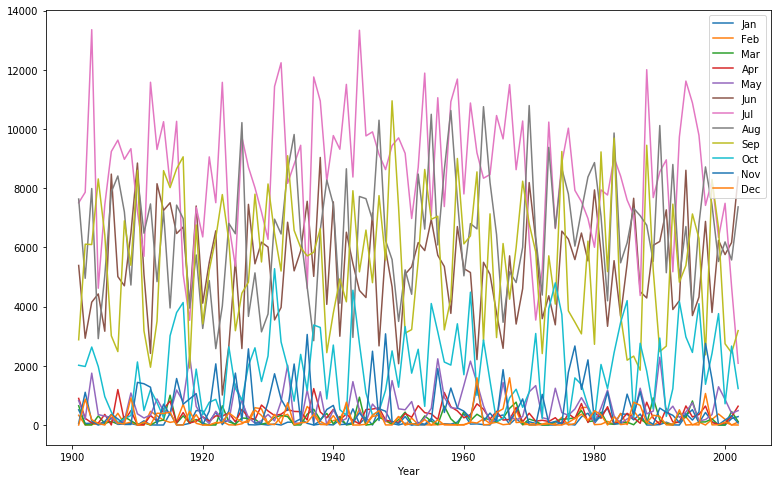

In [59]:
months = list(m_data.columns[1:])
m_data_copy[months].groupby("Year").sum().plot(figsize=(13,8))

## Seasonal rainfall for each year in Maharashtra

In [60]:
seasonal_data = m_data_copy[['Year','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("Year").sum()

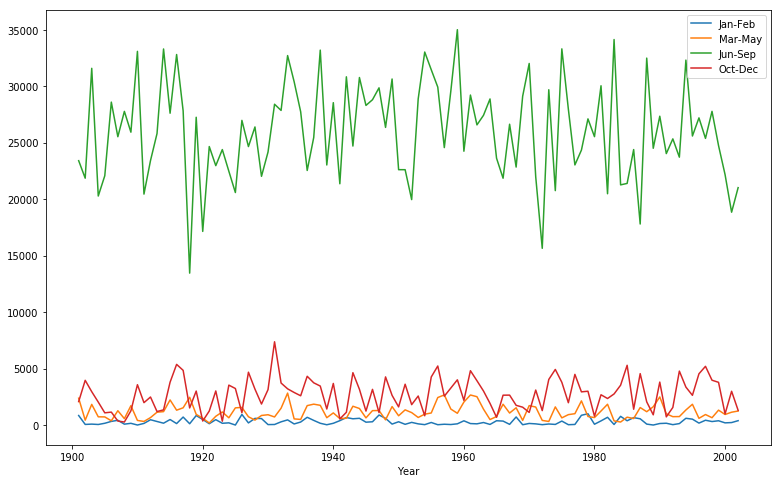

In [61]:
seasonal_data.plot(figsize=(13,8))

## District wise Seasonal rainfall across all years

In [62]:
seasonal_district_data = m_data_copy[['District','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("District").sum()
seasonal_district_data.head()

,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
District,,,,
Ahmadnagar,249.735,4052.170,72472.375,9793.123
Akola,1396.348,2430.082,71598.467,9373.896
Amravati,1570.125,2631.008,76188.207,8760.707
Aurangabad,374.951,3030.083,56120.789,9403.228
Bhandara,3109.308,4954.334,111808.461,7086.156


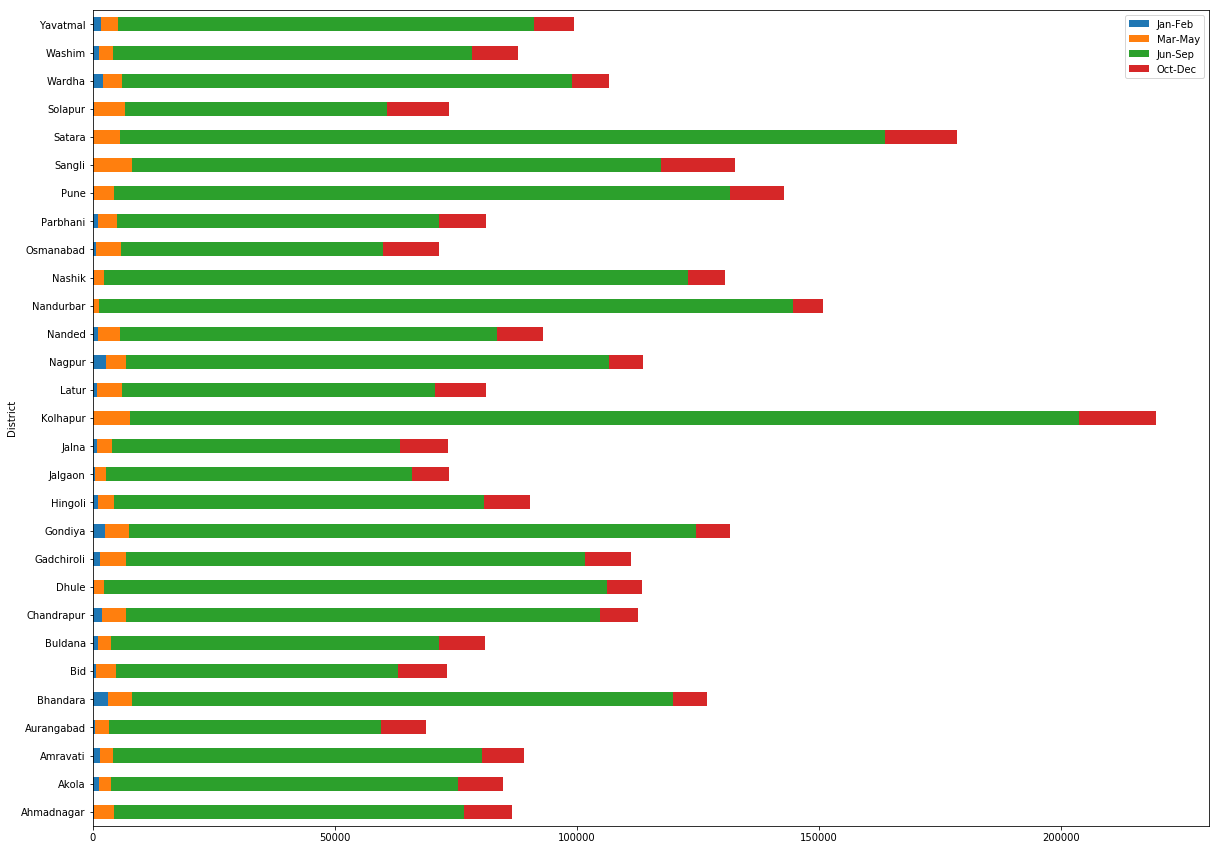

In [63]:
seasonal_district_data.plot.barh(stacked=True,figsize=(20,15));

## District wise Monthly mean precipitation across all years

In [64]:
columns = list(m_data.columns[2:])
columns.insert(0, m_data.columns[0])
monthly_mean_data = m_data_copy[columns].groupby("District").mean()
monthly_mean_data.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
District,,,,,,,,,,,,
Ahmadnagar,0.764765,1.683618,2.516147,10.872980,26.338029,165.464843,233.050088,146.425843,165.572706,66.866951,23.717127,5.426931
Akola,8.296598,5.393088,8.215549,5.283069,10.325716,146.805363,216.788843,183.560373,154.791176,58.458794,23.729500,9.712647
Amravati,9.114353,6.279029,11.095029,5.637853,9.061314,145.434049,250.601422,205.358167,145.549569,53.563343,22.682284,9.643657
Aurangabad,2.308088,1.367902,3.273343,6.156657,20.276696,111.857392,149.430108,105.088363,183.827951,53.443627,30.078951,8.665931
Bhandara,10.836088,19.647324,15.275010,17.592314,15.704578,184.951412,373.926020,338.800657,198.483294,50.267510,9.901167,9.303441


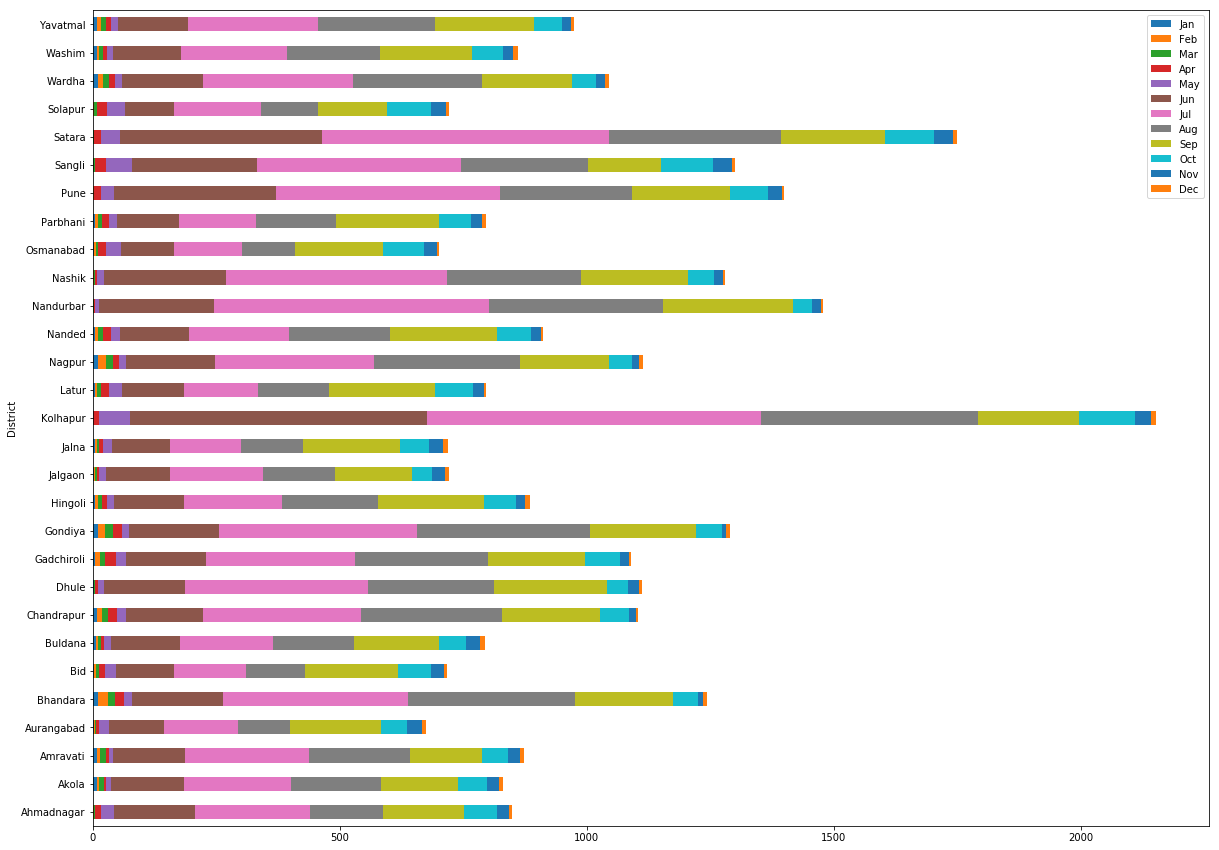

In [65]:
monthly_mean_data.plot.barh(stacked=True,figsize=(20,15));

## Annual rainfall in Maharshtra

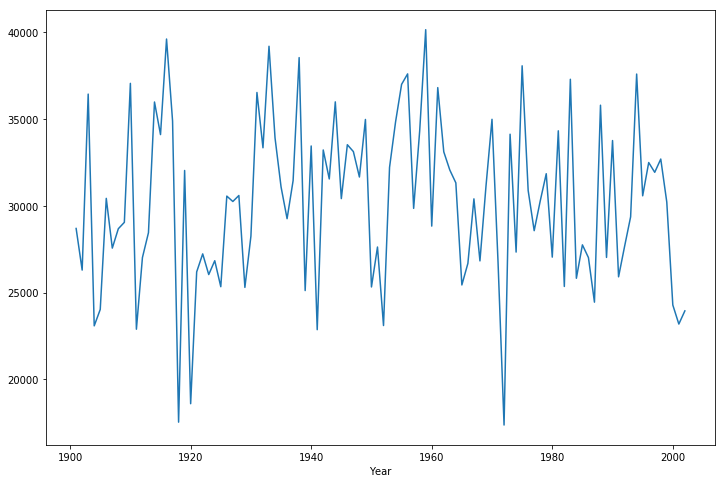

In [66]:
Annual_rainfall = m_data_copy.groupby('Year').sum()['Annual']
Annual_rainfall.plot(figsize=(12,8))

## Best method for each district

In [ ]:
maharashtra_data.Ahmadnagar.head()

In [ ]:
dates

In [ ]:
rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[:-60]})
rainfall_data.index = dates[:-60]
rainfall_data.tail()

In [ ]:
test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[-60:]})
test_rainfall_data.index = dates[-60:]
test_rainfall_data.head()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(rainfall_data)

In [103]:
import Artificial_Neural_Networks as ANN

In [110]:
future_steps = 60
STORAGE_FOLDER = 'State_predictions/'
if not os.path.exists(STORAGE_FOLDER):
    os.makedirs(STORAGE_FOLDER)

parameters_FNN = [[3,6,8,10,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_FNN = [[12], [4], [1], [50], [20], [future_steps]]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[[1,2,3,11,12], [1,2,3,4,11,12], [1,2,3,4,5,6,10,11,12]], [3,4,5,6], [1], [300], [20], [future_steps]]
#parameters_TLNN = [[[1,2,3,4,5,6,10,11,12]], [4], [1], [30], [20], [future_steps]]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6], [300], [20], [future_steps]]
#parameters_SANN = [[12], [3], [50], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[6,8,10,11,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_LSTM = [[12], [4], [1], [30], [20], [future_steps]]

In [111]:
# RMSE_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
#                     parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps, STORAGE_FOLDER)

In [112]:
# ANN.save_RMSE_info(RMSE_info)

In [ ]:
for district in districts[1:]:
    print(district)
    
    rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][:-60]})
    rainfall_data.index = dates[:-60]
    
    test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][-60:]})
    test_rainfall_data.index = dates[-60:]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(rainfall_data)
    
    output_folder = STORAGE_FOLDER + district + '/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    ANN = reload(ANN)
    RMSE_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
                    parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps, output_folder)

    ANN = reload(ANN)
    ANN.save_RMSE_info(output_folder, RMSE_info)

Akola
FNN - Number of combinations: 15
1 -> [65.95759618324041, 44.44326502501964, 62.499311212658874, 65.41566909658908, 73.32405380511284, 73.52764959949255, 73.25442415422201, 71.11090431004762, 69.7938003462553, 68.99930344134569, 69.01753406327963, 69.32563895976543, 69.70684483420848, 69.9386051545739, 70.0130663511157, 69.97062260740995, 69.89062205916643, 69.82322045862674, 69.79101836073399, 69.78941194874048, 69.8040727662444, 69.8206846665144, 69.83143716365099, 69.83476077467202, 69.83298202729225, 69.82937529385089, 69.82635326975583, 69.82486995446682, 69.82477763193845, 69.82543004447221, 69.82618708920478, 69.82667332118749, 69.82683950173855, 69.82675948888063, 69.82659330832958, 69.82645174711942, 69.82637173426151, 69.82637173426151, 69.82640250843762, 69.8264455922842, 69.8264702116251, 69.82647636646031, 69.82646405678987, 69.82645790195464, 69.82643943744897, 69.8264455922842, 69.8264455922842, 69.82645790195464, 69.82645174711942, 69.82645174711942, 69.8264455922

9 -> [66.62460798615217, 22.695597908616065, 0.41940278184413904, 28.54581187301874, 87.39085585188865, 102.79163226580619, 94.34239756679534, 106.81813777911663, 93.28824662828444, 95.9933521028161, 90.82758043467997, 68.0176318424344, 44.0086474905014, 35.207694732606406, 39.991048023760314, 51.54772362107038, 68.52024184167385, 79.01069071376322, 87.23009771066903, 94.8835676087141, 97.7357059419155, 93.0672634243965, 81.80286248737573, 67.64399026048183, 55.53213621628284, 50.12044810676574, 50.75772590070962, 55.74052662730217, 63.764769954085345, 73.24793080306053, 82.37902276754379, 88.92393913853168, 90.76630905002355, 87.1702296284437, 79.67062445616722, 70.78686454516648, 62.96413667845726, 57.954876315236085, 56.55396196019649, 58.825902441322796, 64.19194013798236, 71.32832386434077, 78.31360638594627, 83.26405114376544, 84.94869109296798, 83.15285789060592, 78.63700604796409, 72.74494535887241, 66.98644459414481, 62.72686778056621, 60.93478902769088, 61.96136630439758, 65.

TLNN - Number of combinations: 12
1 -> [36.009198917418715, 7.548696907378733, 11.003119718857109, 14.042681247532366, 41.46269066777825, 111.06768221127986, 147.29349132215975, 142.49432010447978, 61.5761782515645, 67.75600826156139, 96.01121343463659, 54.589437034010885, 38.07476469606161, 18.253757959544657, 17.438442324489355, 24.7152516939044, 55.54410737079382, 102.65870628947019, 130.16963185822962, 116.9679903795719, 77.51157596272229, 74.9601013302207, 76.43798805457352, 56.72144118148088, 40.43167267745733, 26.362134806424375, 24.636562125563618, 34.66083762294054, 62.21897693270444, 96.70315847504138, 115.09145497775077, 104.80449726784228, 82.97530935889482, 75.35081027024984, 69.2445674701929, 56.20196077889204, 42.78264124286174, 32.58376537984609, 31.728978786498306, 42.490501988947386, 65.7276515392661, 91.45599526590108, 104.06107934045791, 97.47452550917863, 83.51761189049482, 74.31457605707645, 66.12467534023523, 55.672835749506945, 45.008189653486006, 37.65759611940

9 -> [38.399361473530526, 10.150966625630854, 12.793859795071183, 23.044032362908123, 38.58426195591688, 111.09684382057189, 148.44167583322525, 146.75214894485472, 65.78525464212893, 69.54180908250808, 95.47296693944931, 50.07966616857051, 38.726687920421355, 20.43225111617148, 23.800641640886663, 33.450341560065745, 55.43142464751005, 103.62536624526977, 132.73318227744102, 122.99133370399474, 83.50539454257488, 77.80814669799804, 74.67597567176819, 51.823614109992974, 39.29336052209138, 28.912978568315502, 32.573403714746235, 42.83886258521676, 64.97876196336746, 99.16219979214668, 119.02444392466545, 111.52405093348025, 89.46600778639316, 78.27980403089522, 67.14670419371127, 51.62851198822259, 40.96088695195317, 35.52081274238228, 39.71272329750657, 50.57986039498448, 70.61756349265575, 95.50664619779586, 109.15379926931857, 104.39559463489054, 89.79804883706569, 76.96648529076576, 64.1416674438715, 51.6464287135601, 43.29007663291692, 40.79826081824302, 45.6386663545072, 56.61115

[7.045359868228435, 4.049906196832657, -15.643412328124045, -0.93168818205595, 79.20778700214623, 174.35099633479118, 221.55422488069533, 203.69129280304907, 129.13720748806, 38.343863324314356, -1.7254834357500075, 2.049006194472313, 6.895705049753189, 11.039823309361934, 51.17030912512541, 122.25415677952765, 184.33464376485347, 201.46412874817847, 161.51693392539022, 84.51415357130766, 16.818234966039658, -4.747827582240104, -0.11337206482887267, 3.9306747288703914, 5.824732946574687, 1.138933793723583, 2.4342496408224106, 28.497182519912716, 85.02341079258917, 150.80180894827842, 185.51932644879815, 170.78124114346502, 117.58943178248404, 59.00243542522192, 22.734847292840477, 8.806282845199107, 15.795381364643573, 29.80771927452087, 64.88169405704735, 114.33475491595267, 156.94375594747066, 169.95280032229422, 142.99080604267118, 88.67813963901996, 36.52791919785738, 9.840559820771217, 3.651448319256305, 6.3186830926537505, 10.571255703747271, 7.445307215929031, 15.652903084039687

7 -> [0.0, 0.0, 10.908189848423003, 23.44592156112194, 56.207106221139426, 83.04494516462087, 134.55023735165594, 173.4199667201042, 129.69175814175605, 67.21741094076633, 24.878274814486502, 9.530306886792182, 6.3609668106436725, 4.25264646911621, 3.497608212828636, 11.899450680613517, 53.82900714206695, 142.58190340971944, 198.12117923486232, 171.00370150780677, 114.90493885111808, 47.283373732775445, 13.759928117334841, 5.6370350915789595, 3.3421740040779113, 0.7518315871357917, 0.0, 9.289566661834716, 68.52107889926432, 175.3767365539074, 210.53982719564436, 171.20592477393149, 105.15756323564052, 36.05956701147556, 10.552698875546454, 4.342482444047928, 2.8455465046763417, 0.1821400387883186, 0.0, 10.813663889050483, 80.62434694832562, 190.00046502077578, 209.2518417572975, 166.64947563815116, 95.68783839195966, 30.45147195512056, 9.385262039899825, 3.852274437785148, 2.6590673070549964, 0.0, 0.0, 14.553034029483793, 93.05867127442359, 198.9232158129215, 205.52854804646967, 160.98

[7.6180088149011125, 5.088836227834224, 8.932592373669147, 17.98022784993052, 23.02773743665218, 101.09756310904025, 194.39145987606048, 202.10476092731952, 142.2225348906517, 82.6402155099511, 38.71113157439232, 14.555419028133153, 8.988376722723245, 4.521434278190136, 5.266237043499946, 10.95071975982189, 21.701530471563338, 113.42935403513907, 200.49149244737623, 195.00555240571498, 158.42249203908443, 82.67495955479144, 28.414498463511464, 13.708356752991675, 8.346193525105715, 3.860583465337753, 3.463350399971008, 4.16022546339035, 18.27517063128948, 122.29401549243926, 205.73031585478782, 199.422779168725, 162.9314012275934, 81.05690876787901, 27.239540419220923, 13.20662074035406, 7.519257561147213, 3.4109912167191503, 2.9321511911153793, 0.0, 13.37992551317811, 126.28748185026645, 208.75226609182357, 202.59671690678596, 167.26202945899962, 81.41757595717907, 27.478215696960685, 13.02437606936693, 7.246536812365054, 3.1396676155328747, 3.1261762167215346, 0.0, 9.285002851516008,

7 -> [74.18738661019503, 33.786196820400654, 8.067494602151214, 29.976845355294643, 85.28149884741008, 106.88536378446221, 99.37439628258348, 106.73648202376067, 97.37446321982145, 99.6557263841927, 97.15516260725259, 79.56075388120114, 56.62954891386628, 45.51291331714391, 48.99690033562481, 59.1614570454657, 73.25164696878194, 82.27351595699787, 88.3365296612531, 94.22588590934872, 97.97703764131664, 96.00800160516798, 87.78404028518497, 76.52513082626461, 66.4518682771027, 61.57634572981298, 61.832236991755664, 65.33037762656808, 70.64786028327048, 77.02780983202159, 83.58807967045902, 88.78681635060906, 90.92567223915458, 89.09749745032191, 84.16211927133799, 78.05928552313148, 72.66354400196671, 69.12906384931505, 67.87246443317831, 68.88757733523845, 71.89067100858688, 76.21738482636214, 80.73298094958066, 84.16116183236241, 85.59556237497925, 84.83144759386778, 82.33654997217654, 78.94756130450963, 75.5528436987102, 72.91361607538164, 71.58672337314486, 71.83353858447074, 73.528

[40.194798907674844, 7.709133826240897, 0.0, 8.278903210049494, 31.34172758803144, 106.81547073924541, 164.54067514702677, 154.04632779726384, 82.87787969067692, 78.99850961458682, 101.94160409051179, 66.08677011299133, 42.496125127300616, 12.793276048019528, 0.7028602682910859, 10.674754946896806, 44.52161082370579, 105.13653086483478, 145.72287130242586, 135.65406633800268, 100.43381035691499, 90.26310877233743, 87.65135650846362, 66.49390141770243, 42.42059731827676, 16.129261247152463, 4.569756170187145, 15.887395092826337, 51.56236591853201, 101.17720678642392, 131.91357200053332, 127.94663549748063, 107.79149344837666, 94.53834062552451, 83.57728101447225, 65.25008616624773, 41.95444225507974, 18.866491970866917, 9.219848925892263, 21.48090858336538, 55.269004585996264, 96.73241406023502, 122.50312404972314, 123.37987132409215, 110.44240653592348, 96.60479215350746, 82.45389118170738, 64.05341301254927, 41.73616971223056, 21.40384651762247, 13.87912073538266, 26.46838478398323, 5

7 -> [37.23829013399035, 11.15004786261171, 5.988136286666617, 13.55924881009385, 35.63656928253174, 107.24799772039056, 163.78721776041388, 157.75894653439522, 76.63977237179876, 71.83919689185917, 97.77282061654329, 59.299226235762234, 39.63333942710608, 19.19981807192415, 13.30952204253897, 22.24849996665865, 51.900777433164414, 106.64452079494296, 146.12504275932906, 135.3745412442982, 90.8136832704544, 78.74891626065968, 76.95372602932154, 56.13049169570952, 40.04135754004866, 25.180550883233547, 21.224503286562857, 32.095402752771975, 61.82053583181649, 104.62668676248192, 131.97822267496585, 123.45180481302738, 95.30807447472215, 78.93430626820027, 67.8032070646584, 52.907273384444416, 40.21387313251197, 30.04904959541559, 28.843339630402625, 41.03060781797767, 68.26004671749472, 101.89907653470337, 121.51432502377033, 115.46123101513088, 95.02735650622844, 77.30733492572605, 63.22715494842082, 50.661368755355475, 40.73511232824623, 34.32542723622918, 35.73496575692296, 48.52874

2 -> [17.96872812619805, 4.4704395341575145, -13.17627518182993, 8.428625672802328, 87.07955354781448, 184.04376986232398, 234.98727704891562, 205.50495284843444, 115.43057727219164, 30.219975996136665, -1.0774720012396573, 9.03506124164164, 10.650425598502158, 7.750452811539173, 42.88729388384521, 114.18366996371745, 189.0410676603019, 214.95589575919507, 172.17414775061607, 89.81670677390694, 20.494715047083794, -3.6555647916197773, 7.704432957828044, 16.907199053473768, 15.136152764827012, 6.625940734729171, 4.205174002900719, 29.654027539387343, 92.60068818333744, 162.78718059828876, 197.99437773957848, 176.57433323797582, 112.80211691340803, 49.53002903994918, 19.880839706532655, 15.643603269740938, 17.885266130253672, 24.769746779829262, 57.347973451405764, 110.80978057956695, 164.62337590050697, 183.56900569620728, 153.71307625088096, 93.15523369884491, 37.39415256656706, 10.780295917250216, 11.753489472687244, 16.861583364576102, 17.646863825336098, 12.113251091688872, 17.36844

5 -> [30.94000149720907, 17.685577320963144, 18.091535370536146, 15.087017310515046, 31.340517055556177, 33.09085676439106, 54.28353305287659, 114.82721021679043, 158.18638810196518, 139.9861480923295, 94.1537012888789, 47.18213754031062, 22.014947639502584, 9.853326259896159, 5.937730459943413, 3.8627640033662316, 0.9651063352376222, 13.963603934168814, 76.81076940326392, 186.6445665130019, 223.87403172791002, 160.63507752129433, 91.12366591058671, 33.73124610149115, 9.648701146379112, 5.554244758784771, 8.1121371563524, 6.06464605922997, 1.012970436155796, 13.785171054922044, 92.79165017180144, 217.71305318158863, 224.12858492964506, 151.19320673722027, 78.83839756557344, 26.80220530024916, 7.831285774230957, 6.163843015387654, 7.712006143167614, 5.7000815496295685, 0.07878467111289501, 20.70409596403688, 114.018543131873, 232.48222429579496, 212.41301631867884, 140.76744968783854, 67.19694414874911, 21.834674436978993, 6.445636140763759, 7.193458763569593, 7.390385125979781, 5.70712

13 -> [15.831767495952546, 0.0, 6.652415491975844, 16.46417163503915, 27.868447013176976, 82.40743184781074, 171.29980192154645, 195.4020410824716, 131.9819896479845, 76.92224041317402, 60.297607499331235, 25.83769147847593, 5.171692953020334, 0.0, 4.941636847697198, 14.72380655684322, 36.67508450447023, 106.72622487014532, 198.23681384477018, 200.06352893155812, 144.64046299695968, 75.86485108684003, 33.2264638691321, 11.518999326206742, 1.60521707329154, 1.315525076366961, 5.613107636131346, 12.58522534341365, 42.81355538700521, 141.39441525962948, 224.85019569852946, 196.27816052800415, 135.2802884402275, 61.226880503728985, 21.512402047373353, 6.107201082549989, 1.1375905362591148, 2.8276272853538393, 6.5229414901807905, 10.329934673219919, 51.04784056741744, 176.20755563172696, 236.57460100036857, 188.26047237223386, 122.37434065964817, 47.01407560865581, 16.440149334184824, 3.8553870145380493, 1.4059206570237874, 3.8346176518425343, 6.847811521597206, 8.43916927332431, 62.7266576

5 -> [25.946903277847916, 31.60687353248894, 44.34245982821285, 50.717344858109946, 51.96498543515056, 71.65789426589012, 73.56324188691377, 72.01756303447485, 67.75440712431073, 61.251966618523, 55.09709159007668, 48.89638290181756, 47.57590468996018, 48.86209024329483, 52.2741746231839, 56.83915723730623, 60.89042120721936, 63.580950518935914, 64.01610671374202, 62.658949625372884, 60.0864520034641, 57.16288864925504, 54.81231984326243, 53.584693274244664, 53.69836721691489, 54.89537358366698, 56.69096572013199, 58.49358999532461, 59.78459367069602, 60.278228020638224, 59.9470462668091, 59.008253989517684, 57.814456189811224, 56.74044020739198, 56.07376815296709, 55.94298653846979, 56.30756831552088, 56.99176624492556, 57.75558091739565, 58.371211101315915, 58.68586855914443, 58.65445412231981, 58.33621206603944, 57.86303452745825, 57.39140680056065, 57.05459160426259, 56.92830830939114, 57.01762103983759, 57.26582988244295, 57.57955253322422, 57.86042690780013, 58.03374927157164, 58

13 -> [24.946728266380727, 1.5146316612400115, 0.0, 23.736200583409516, 49.167153628796335, 126.30952569776773, 110.73982935076951, 131.09108483031392, 77.12510273878276, 58.449755979157985, 81.80386121062934, 35.736460978575046, 25.881048581387848, 8.965604360602796, 11.609952095597983, 32.706681052200494, 60.11749743750691, 101.69794684369862, 99.20434553085268, 110.38089155912398, 86.20571999500692, 69.84746118897199, 67.77923222574591, 39.08003384197503, 27.71779682811722, 17.10002292655781, 21.922158307854087, 39.05998469083011, 62.01865599837899, 88.33958928164839, 92.6419086870551, 99.22899491667746, 86.72281589324771, 72.99566640812158, 62.72707808183133, 42.162278935298325, 31.071731641061604, 24.32772434274107, 29.43539056228846, 43.285330115951595, 61.771656079173084, 80.6155457379669, 87.56749488961697, 91.97922889129818, 84.49072860902548, 72.9755434564203, 60.898841499269004, 44.922813346192235, 34.95168343378603, 30.3610920266062, 34.94234942056239, 46.229185108847915, 6

5 -> [31.826669160895047, 18.755388734467328, 8.766175928596407, 22.60106016876176, 35.369746014013884, 121.58673992258309, 125.08132981017232, 134.6347345163226, 64.38347885468602, 47.94527647455036, 76.84147665774822, 33.912016338884825, 37.10198564431071, 27.524513171005992, 19.949190048485992, 31.257115124329925, 47.41351886577904, 95.29911529041826, 107.23700191536545, 109.3137073996365, 71.67204288683831, 55.61505200912058, 58.05934752169251, 35.94380891314149, 38.20670617248863, 32.70400666061044, 29.493295884534714, 38.46031651295721, 52.36789078682661, 81.00640754170715, 92.89077119173109, 93.16483131493628, 71.98007235184312, 57.74514692445099, 51.115959234580394, 38.200661555491386, 38.90570638491213, 36.431103443861005, 36.413904399916525, 43.64636595198512, 54.59599284100532, 72.67102127499878, 82.18214177666604, 82.19352814821899, 69.57844761809706, 57.75382024697959, 49.044764191851016, 40.42806426154077, 40.05447178798914, 39.422134563833474, 41.17408245699107, 47.15753

SANN - Number of combinations: 4
1 -> [-13.489216491416096, -32.29586146943271, 20.25285825204104, 40.07922660318017, 79.92387989512086, 133.78927534264326, 139.7351823385954, 145.19254370868205, 104.82033592537044, 65.96869371946156, 16.69543246217817, -18.697553698465228, -8.131296099558472, 26.499899632446468, 63.02126818536222, 99.89804967477917, 125.80238233169912, 131.16481510043144, 120.95367172148823, 88.36650891315936, 51.30504328860342, 13.688052761815488, -12.439129460819064, -17.752899548411367, -10.568717617452144, -6.23738405045867, 18.078054256804286, 47.468032876744864, 82.08066952598095, 111.42184489229321, 125.59218428993225, 120.21395117351412, 97.77501149836182, 64.46503198377788, 28.161505101680753, 1.5223789625018835, 7.509863786183297, 31.57460511779785, 63.328847818404434, 90.18620571705698, 110.16291985875368, 116.73772005289793, 107.31759915153681, 82.6331615767777, 51.78961422736197, 22.346451763626188, 1.2535375929251313, -2.9677944876551625, 3.4028944534659

4 -> [3.409585703909397, 1.7354235971570013, 0.0, 10.419879466831684, 21.126625210553406, 59.35240355539322, 91.35771574874222, 133.94882511687277, 133.3166144079566, 102.89416951882839, 57.969391672112046, 19.142057963743806, 10.58463745175302, 7.447228199705481, 4.996508524417877, 4.613434436529874, 16.58116460074484, 53.580739673011, 99.63299321945011, 129.99523794046044, 133.8879010004401, 110.82937402582168, 61.85117793580889, 20.934842164754865, 10.209800911679864, 7.3527634875625365, 5.146576684311032, 4.389860922500491, 14.376910669207572, 49.08112678026408, 96.58521298594772, 128.96772333717345, 134.87197870483993, 114.60048405516147, 66.65600884379447, 23.17730369861424, 10.518582439497113, 7.618775835812092, 5.238054231077433, 4.280537698343396, 12.436989244684577, 44.95545779228955, 92.52091794636846, 127.23176556456089, 135.4085438927114, 117.85328926286101, 71.64666955269873, 25.82032653790712, 10.883227474167942, 7.917900033682584, 5.359522918224335, 4.2669935390949245, 

12 -> [7.187734900601208, 14.134535584867, 0.0, 2.0487456163465976, 50.51520864854753, 77.44416714411973, 99.25768576154113, 127.49595749908686, 160.0940709042549, 95.54144117438793, 46.21314930224418, 22.784055676884947, 18.60123342947662, 10.898226558670402, 9.836341981992126, 25.476236715339123, 44.597897611029445, 80.31074944019318, 112.80483217538892, 124.16652622801065, 113.1132130716145, 76.98538071402908, 44.859963386669754, 27.056447199530897, 17.34306045874953, 14.562789670497178, 18.062566682904958, 28.583616169571876, 53.976560171276326, 87.12847295138239, 112.13260750767589, 118.78617046701908, 102.81702333724498, 70.27628459317982, 41.68544299770892, 25.745137828223406, 19.358947255954146, 17.5957957354784, 20.93501788036525, 35.14864657577872, 61.63644643129408, 91.36650152926147, 111.21840838721394, 113.59385149501263, 93.9848960686028, 62.87356164327264, 38.528227082058784, 25.792159325562416, 20.206764533124865, 19.056575833603738, 24.763045710220933, 41.3819715956374

4 -> [72.0663038405031, 66.60861951339244, 51.5816077459827, 86.7340160498619, 122.223643236354, 130.63200763274727, 126.50104257887601, 113.17633211638032, 107.67945324069261, 99.23599730631709, 89.44925889277458, 83.83827313296496, 84.78327745342999, 92.36604593506455, 99.88804127161204, 105.22059457297622, 107.72905647930503, 107.83513010057807, 105.95811072739959, 102.2530381732732, 98.32806584605574, 95.59690764099359, 94.85108828881383, 95.83516298779844, 97.74879633183777, 99.89708948971331, 101.64651603078842, 102.58148417139053, 102.520122568205, 101.63386148232222, 100.36875215238332, 99.19922137451171, 98.46646687185763, 98.29248842523991, 98.61937959828973, 99.26128480845689, 99.96973437203467, 100.51654691296815, 100.76112953400612, 100.68593646615743, 100.3763967089653, 99.97177507993578, 99.61177908982336, 99.3958095689863, 99.36243481701612, 99.4881381047666, 99.70509018866717, 99.92995676405728, 100.0927815002948, 100.15602185043691, 100.11945106916129, 100.01297794422

11 -> [93.51624937355518, 84.94493607086687, 38.75309972860291, 6.810905809573828, 46.44572901826351, 109.08259648495913, 186.80858234259486, 193.59664626029132, 156.4972460564971, 120.51578667104243, 99.86458932684361, 100.5784375885725, 94.6882635525763, 70.739309233658, 45.19540132386237, 36.02569091940671, 64.78220753668248, 110.46872303265333, 145.70790461191535, 155.9275862249881, 144.3939586585015, 128.82766553407907, 118.05305173805355, 109.10790558189153, 94.94219671881199, 73.25470846711099, 56.21330205336958, 55.84798834557831, 74.43766580728442, 102.1695203128755, 124.77664440242945, 135.1269961055517, 134.90289614529908, 129.86728203964233, 123.16384811416268, 112.82249064216018, 97.40889429624379, 80.10046287325024, 68.27098664808273, 68.08441303867846, 79.49194321244954, 96.70055270662904, 112.47300051864981, 122.66442534559964, 127.16056913980842, 127.17078347671031, 122.93397154688834, 113.86250665138661, 100.76404483100771, 87.18098506718873, 78.02762192073465, 76.701

3 -> [35.154443613082165, 11.816851369541137, 5.816007395633496, 10.358521957936697, 27.59944603473693, 107.48372883792221, 218.67996963602303, 232.91888484603166, 193.3822963488996, 90.29677352202683, 56.749414374567564, 62.250525829605756, 35.154859312839804, 16.874486764956266, 9.228234316925517, 15.006399537868797, 43.75992797571793, 117.43041988028585, 198.0996356037557, 217.16928432458639, 175.08231842868028, 97.21977790001034, 58.425467209070916, 47.59903130949289, 31.855480029325932, 19.134168562434613, 13.614185958009212, 22.288409244854, 56.146001882217824, 121.31321757754682, 184.59423071414233, 200.599362416476, 162.17805857819317, 98.59414608313143, 57.62992044822126, 39.939018254712224, 28.4664715591073, 20.34234862037003, 18.29350488113612, 30.224916625443843, 65.51925400436669, 122.70498036611079, 173.88726260595024, 185.68256507182122, 151.56057929055393, 96.96102909502386, 56.12516290735453, 35.54698835434765, 25.883737062964588, 21.3528769402951, 22.98774310660362, 3

11 -> [47.8533693780899, 30.52272231220454, 20.78429414906725, 25.5660425722152, 33.63854315923154, 112.81764261122048, 220.28714048081636, 244.573723983407, 204.46046814456582, 98.7178626499623, 73.09387045179307, 83.66814935682713, 64.85792427825183, 48.652306521378456, 37.353306376539166, 38.676511097282166, 56.767489215977484, 124.79050825928151, 204.9980273168683, 235.01645183607934, 193.84740499201416, 116.94264750233292, 87.44831780223548, 84.82436154635995, 75.62009407503902, 62.13706678926199, 51.50416342100501, 52.10165354148298, 73.95676597207785, 131.25258798521756, 196.28686073857546, 222.3509116204381, 187.72664176058768, 128.57685281537474, 97.45373588308692, 89.42809059732407, 83.2903862510994, 72.67450497811288, 63.45344755554199, 64.5746221940741, 86.69000586253404, 135.58371517173944, 189.35186585199833, 210.63161202713846, 183.1429958667457, 135.69812438295781, 105.30279515102505, 94.71417730370163, 89.38087358329444, 81.10402147386223, 73.58293851730227, 75.4921611

2 -> [63.74545234113931, 63.925110218212005, 55.7483931620866, 105.456560871765, 183.50302424904703, 211.60344247871637, 198.03899742612242, 133.40843932050467, 76.67049178081005, 49.114845384173094, 40.62695276531577, 44.034554351966825, 52.893604769363996, 81.27589982689916, 144.80853548692167, 220.19300877985359, 233.06346198251842, 173.71684730011225, 96.2487248609662, 48.69069666393101, 34.5771284275949, 33.7104700146988, 37.74135940094292, 50.0029474261254, 93.59656040725112, 182.56913584807515, 257.21892190441486, 233.93368893489242, 147.79185608522593, 67.06534937697649, 32.629248441834, 26.07689168541506, 27.29758592566475, 30.411614404905585, 45.18610476564616, 103.72331962774693, 212.94922995382547, 282.54199066764113, 233.4052859546542, 129.69824880053102, 49.618398156821726, 23.760107857592402, 20.159065517488866, 22.31251713144779, 23.450411538153887, 39.23488764965534, 106.5259673937261, 229.60935331064462, 300.32420104297995, 237.7593576083183, 122.79806471963226, 41.35

10 -> [29.933497598595917, 17.294227448157965, 10.209186543866991, 11.769960976749658, 10.696208502776921, 85.76157014669478, 217.47087719810008, 276.609123726666, 232.98895994803308, 154.52866476267576, 84.86771849121153, 25.730864826768634, 9.48334237484634, 12.951244720496236, 13.910058910831808, 4.79922670841217, 0.0, 42.19857858148217, 181.23302284005283, 321.36143769717216, 324.6063144235015, 206.61560685169695, 69.58030051848291, 11.880348157845438, 0.7183723707795143, 10.648106102250516, 14.509076862886547, 9.197600079104303, 6.5502188719511025, 13.821244927547871, 164.81914490330217, 350.2909232045114, 354.31798491376634, 224.45916803282498, 63.71144054278731, 8.241037145897746, 0.0, 8.958016652554273, 16.107728561997412, 11.813112771071493, 12.007325538359582, 8.451575576394795, 163.20455624724923, 357.2306041610837, 358.619127730757, 226.1951086259186, 60.4556962370798, 7.567031276524067, 0.0, 8.801843112438917, 16.45876271317899, 12.36006027945876, 13.116542060486971, 8.135

2 -> [53.6969028634876, 38.90855314747989, 53.83722114222497, 53.4237408387959, 57.58488557329774, 56.75079870937765, 56.962021236598495, 56.23539082784951, 56.09202178774774, 55.906856312312186, 55.93534124772996, 55.95012287304551, 55.991822193034, 56.006617213569584, 56.0154178731367, 56.013780307486655, 56.01159018900991, 56.00893458663673, 56.007806039348246, 56.007387438721956, 56.00752808853239, 56.00772901683301, 56.00790985230357, 56.007980177208786, 56.00800696764887, 56.007983526013795, 56.00797682840377, 56.00796678198874, 56.00796343318373, 56.00796343318373, 56.00796678198874, 56.00796678198874, 56.00796343318373, 56.00796008437872, 56.00796678198874, 56.00796343318373, 56.00796678198874, 56.00796343318373, 56.00796678198874, 56.00796343318373, 56.00796678198874, 56.00796343318373, 56.00796678198874, 56.00796343318373, 56.00796678198874, 56.00796343318373, 56.00796678198874, 56.00796343318373, 56.00796678198874, 56.00796343318373, 56.00796678198874, 56.00796343318373, 56.

10 -> [22.474265768900516, 0.6550530504584313, 0.0, 22.479941993393005, 64.90239958700538, 86.58308563739061, 82.15715089072287, 98.68941090868414, 98.1957769573331, 82.92445588512719, 68.46941942940653, 45.69585756151378, 26.55209558355063, 21.538837367758155, 27.959682049512864, 37.37884580920637, 51.449466240182524, 67.76675306931138, 79.44956166855991, 86.26423921474814, 85.93732886964084, 77.08818530358374, 63.879460213333374, 50.92291018677503, 40.66365180697292, 35.248510199502114, 36.11782314332575, 42.27123895456642, 51.96360157580674, 62.960454351961616, 72.04207196183503, 76.80399901279807, 76.52204302614928, 71.63671251055598, 63.63372490167618, 54.80950984011591, 47.40880146353692, 43.1267414265275, 42.92784250174463, 46.65244706151635, 53.05390551106632, 60.324938111230736, 66.57199320816994, 70.2632470188439, 70.64121994274855, 67.84129746884108, 62.760115441024304, 56.82228899873793, 51.60079204098881, 48.37767438031733, 47.84104847024381, 49.956301062181595, 54.0117642

2 -> [22.490340032950044, 8.8990290398933, 15.501804251443595, 24.578323305688798, 37.24001105108857, 109.6727880934775, 118.92360742530227, 137.96643976905943, 66.05322312641144, 61.75775782294571, 85.37627677582205, 37.986553454428915, 28.746122115746143, 18.02633272211999, 21.84473061262071, 28.692514445140958, 47.86621139109135, 89.66226496110856, 104.93478490550817, 107.92492620161177, 70.71356082858145, 65.87568287998438, 67.74471793234349, 43.171622111275795, 33.07926817318797, 25.13424670463428, 26.962444754295053, 33.52577104282379, 51.101880372941494, 77.94831247526407, 91.3443764154017, 90.35300287775695, 70.45116186319292, 64.629344724074, 59.79740085795522, 45.13884412653744, 36.28955991066992, 30.39584392797947, 31.291910475030544, 37.395194675266744, 51.68319273707271, 70.07347693651914, 80.36501109901072, 79.10693203273416, 67.9138727710247, 62.0395798573941, 55.78740778639913, 45.91320170429349, 38.70765163730085, 34.29077205938101, 34.83895804435015, 40.1848564106226,

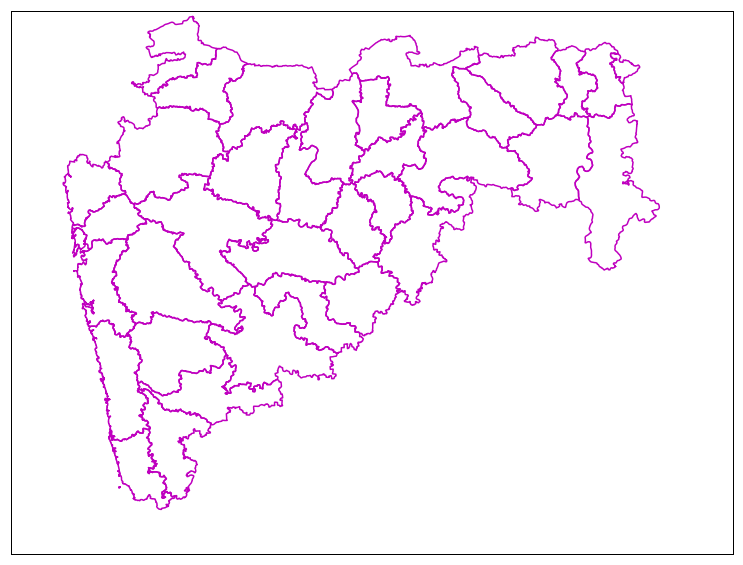

In [9]:
plt.figure(figsize=(15,10))

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
#map.drawcoastlines()

#map.readshapefile('sample_files/comarques', 'comarques')
map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None,color='m')
plt.show()

In [10]:
maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


In [11]:
maharashtra_data

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193
5,1901-06-01,1901,Jun,262.971,148.203,142.860,171.109,143.611,212.705,164.163,...,268.118,182.832,172.452,411.281,200.694,337.832,154.065,128.469,119.965,104.916
6,1901-07-01,1901,Jul,162.397,236.155,269.763,157.499,237.044,168.635,236.043,...,328.410,151.967,172.251,370.136,295.039,487.674,165.925,228.241,190.457,223.163
7,1901-08-01,1901,Aug,120.152,295.033,282.384,141.114,368.424,154.044,267.994,...,230.975,107.738,210.149,284.110,272.462,405.435,105.419,385.983,321.405,365.451
8,1901-09-01,1901,Sep,58.708,56.731,55.108,58.109,127.879,69.839,74.608,...,65.635,74.486,84.709,127.122,131.615,163.785,65.929,114.336,70.608,121.423
9,1901-10-01,1901,Oct,62.633,119.066,42.729,140.062,3.565,84.208,162.570,...,66.428,45.068,82.933,56.783,76.434,73.775,42.468,29.613,122.672,63.198


In [12]:
year_precipation = pd.DataFrame({'Precipitation': maharashtra_data.ix[0][3:]})
year_precipation.index = maharashtra_data.ix[0].index[3:]
year_precipation.head()

,Precipitation
Ahmadnagar,2.51
Akola,34.202
Amravati,35.651
Aurangabad,10.922
Bhandara,23.397


In [13]:
num_colors = 9
values = year_precipation['Precipitation'].astype(float)
cm = plt.get_cmap('rainbow')
# rainbow, spring, PuRd, plasma
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
year_precipation['bin'] = np.array(np.digitize(values, bins) - 1)
year_precipation.sort_values('bin', ascending=False).head()

,Precipitation,bin
Wardha,45.05,8
Amravati,35.651,6
Akola,34.202,6
Hingoli,28.902,5
Parbhani,33.207,5


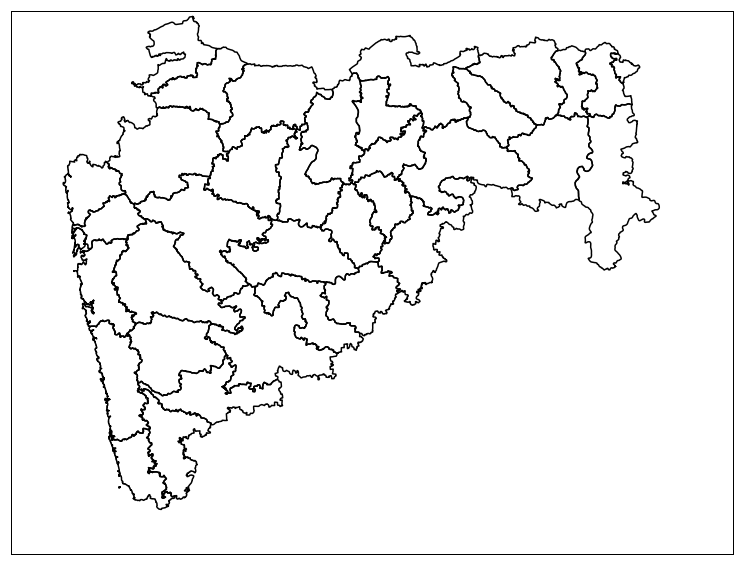

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
#map.drawcoastlines()

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='black')
        
        district = info['NAME_2']
        if district not in year_precipation.index:
            color = '#dddddd'
        else:
            color = scheme[year_precipation.ix[district]['bin']]
            color = '#ffffff'
            patches = [Polygon(np.array(shape), True)]
            pc = PatchCollection(patches)
            pc.set_facecolor(color)
            ax.add_collection(pc)
    else:
        color = '#dddddd'

plt.show()

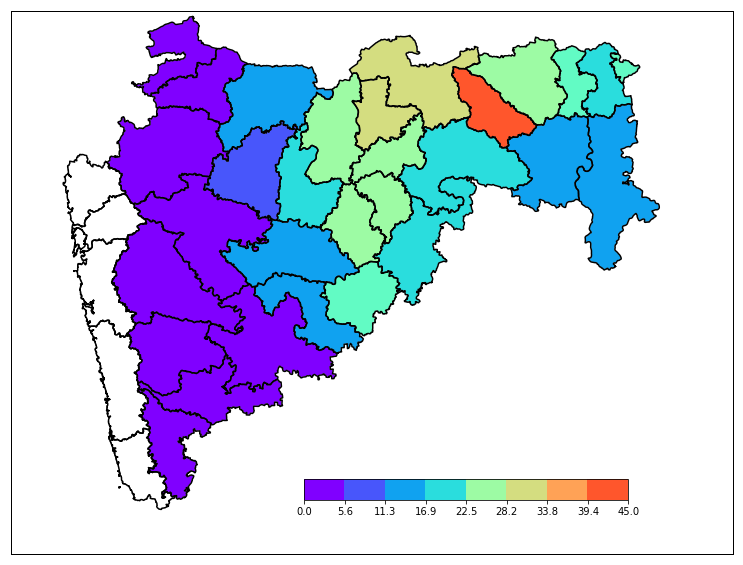

In [23]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
# map.drawcoastlines()

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='black')
        
        district = info['NAME_2']
        if district not in year_precipation.index:
            color = '#dddddd'
        else:
            color = scheme[year_precipation.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
    
#ax.axhspan(0, 1000 * 1800, facecolor=facecolor_array, edgecolor='w', zorder=2)
ax_legend = fig.add_axes([0.45, 0.20, 0.3, 0.03], zorder=3)
cmap = matplotlib.colors.ListedColormap(scheme)
cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()

In [26]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)
latlon_data.shape

(29, 3)

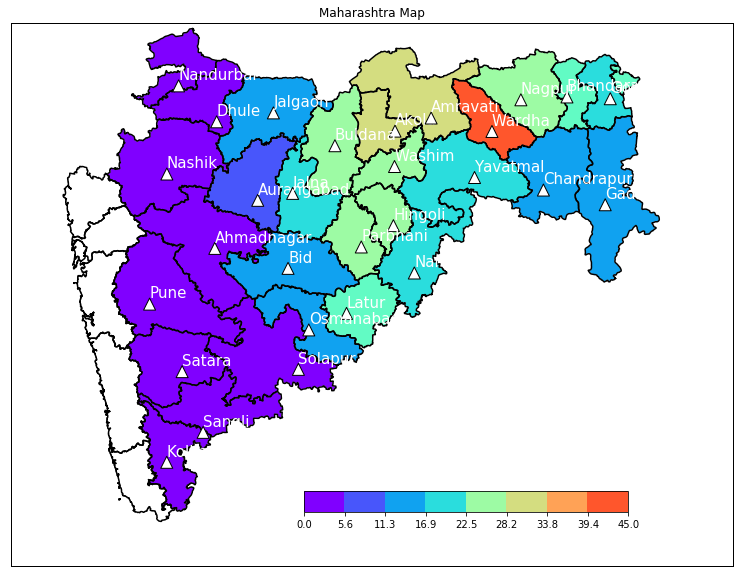

In [27]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
# map.drawcoastlines()

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='black')
        
        district = info['NAME_2']
        if district not in year_precipation.index:
            color = '#dddddd'
        else:
            color = scheme[year_precipation.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
ax.set_title("Maharashtra Map")    

lat = latlon_data['lat'].tolist()
lon = latlon_data['lon'].tolist()
label_dist = latlon_data['district'].tolist()

X,Y = map(lon,lat)
ax.scatter(X,Y)
for i, (x, y) in enumerate(zip(X, Y), start=0):
    ax.annotate(label_dist[i], (x,y), xytext=(0,0), textcoords='offset points',fontsize=15,color='w',arrowprops=dict(facecolor='white', shrink=0.05))

#ax.axhspan(0, 1000 * 1800, facecolor=facecolor_array, edgecolor='w', zorder=2)
ax_legend = fig.add_axes([0.45, 0.20, 0.3, 0.03], zorder=3)
cmap = matplotlib.colors.ListedColormap(scheme)
cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()